In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

Loading data

In [260]:
DATA_FILENAME = 'master.csv'
df = pd.read_csv(DATA_FILENAME)
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


Dropping unecessary columns

In [262]:
df = df.drop(columns=['country-year'])
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,NaN,"2,156,624,900",796,Boomers


Let's see how many elements of df are null or NaN

In [263]:
df.isna().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

We've got a lot of NaN in "HDI for years" columns. We can just drop this columns, but HDI could get information about reason of suicidies numbers, so we should approximate it. We'll assumpt that is a linear corelation between year and HDI and use LinearRegression from sklearn to predict HDI level.

First we need to assign every NaN as 0

In [264]:
df.loc[df['HDI for year'].isna(), 'HDI for year'] = 0
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,0.0,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,0.0,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,0.0,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,0.0,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,0.0,"2,156,624,900",796,Boomers


In [265]:
from sklearn.linear_model import LinearRegression

def get_HDI_predicted_by_year(x_train: pd.Series, y_train: pd.Series, sample: pd.Series) -> np.ndarray:
    y_filtered = y_train[y_train > 0].values.reshape(-1 ,1)
    x_filtered = x_train[y_train > 0].values.reshape(-1 ,1)
    
    if len(x_filtered) == 0:
        return np.zeros(len(sample))
    
    return LinearRegression().fit(x_filtered,y_filtered).predict(sample.values.reshape(-1 ,1)).ravel()

In [266]:
def complete_HDI_column(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    for country in df['country'].unique():
        temp_df = (
            df.query(f"country == '{country}'")
            .groupby(['year'])
            .agg({
                "HDI for year": 'median'
            })
            .reset_index()
            .copy()
        )
        
        df.loc[df['country'] == country, 'HDI for year'] = get_HDI_predicted_by_year(
            x_train=temp_df['year'], y_train=temp_df['HDI for year'],
            sample=df.loc[df['country'] == country, 'year']
        )
    return df
        

<Axes: xlabel='year', ylabel='HDI for year'>

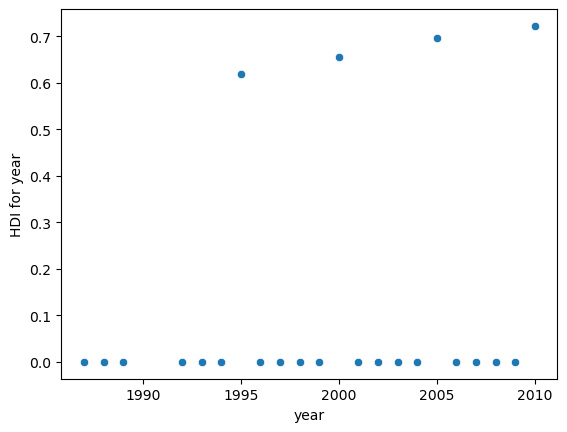

In [267]:
sns.scatterplot(df.query("country == 'Albania'").groupby('year').agg({'HDI for year': 'median'}).reset_index(), x='year', y='HDI for year')

In [268]:
df = complete_HDI_column(df)
df.head(15)

,country,year,sex,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,0.56512,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,0.56512,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,0.56512,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,0.56512,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,0.56512,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,0.56512,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,0.56512,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,0.56512,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,0.56512,"2,156,624,900",796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,0.56512,"2,156,624,900",796,Generation X


<Axes: xlabel='year', ylabel='HDI for year'>

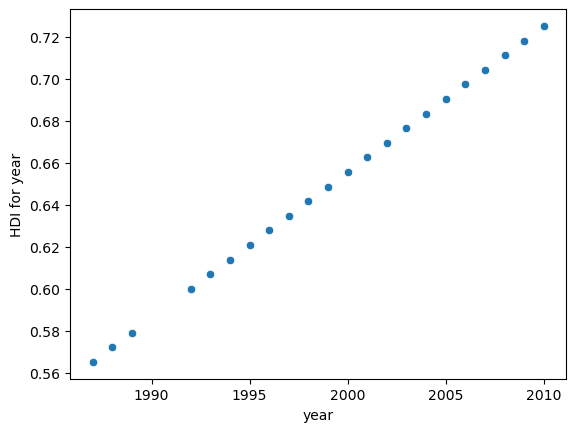

In [269]:
sns.scatterplot(df.query("country == 'Albania'").groupby('year').agg({'HDI for year': 'median'}).reset_index(), x='year', y='HDI for year')

Next let's assign the "age" column as a pd.Interval object.

In [270]:
df['age'].unique()

array(['15-24 years', '35-54 years', '75+ years', '25-34 years',
       '55-74 years', '5-14 years'], dtype=object)

In [271]:
def age_lower(x: str) -> int:
    if '+' in x:
        return int(x.split('+')[0])
    
    return int(x.split('-')[0])

def age_bigger(x: str) -> int:
    if '+' in x:
        return 100
    
    x = x.split('-')[1]
    x = x.split(' ')[0]
    return int(x)

def to_interval(x: str) -> pd.Interval:
    return pd.Interval(left=age_lower(x), right=age_bigger(x), closed='both')

In [272]:
df['age'] = df['age'].apply(to_interval)
df['age']

0         [15, 24]
1         [35, 54]
2         [15, 24]
3        [75, 100]
4         [25, 34]
           ...    
27815     [35, 54]
27816    [75, 100]
27817      [5, 14]
27818      [5, 14]
27819     [55, 74]
Name: age, Length: 27820, dtype: interval

In [273]:
df

,country,year,sex,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,"[15, 24]",21,312900,6.71,0.565120,"2,156,624,900",796,Generation X
1,Albania,1987,male,"[35, 54]",16,308000,5.19,0.565120,"2,156,624,900",796,Silent
2,Albania,1987,female,"[15, 24]",14,289700,4.83,0.565120,"2,156,624,900",796,Generation X
3,Albania,1987,male,"[75, 100]",1,21800,4.59,0.565120,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,"[25, 34]",9,274300,3.28,0.565120,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,"[35, 54]",107,3620833,2.96,0.677957,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,"[75, 100]",9,348465,2.58,0.677957,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,"[5, 14]",60,2762158,2.17,0.677957,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,"[5, 14]",44,2631600,1.67,0.677957,"63,067,077,179",2309,Generation Z


In [274]:
df.isna().sum()

country               0
year                  0
sex                   0
age                   0
suicides_no           0
population            0
suicides/100k pop     0
HDI for year          0
 gdp_for_year ($)     0
gdp_per_capita ($)    0
generation            0
dtype: int64

EDA

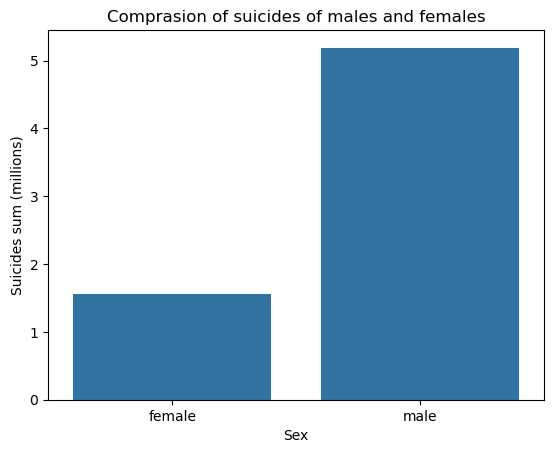

In [300]:
grouped_df = df.groupby(['sex']).agg(suicides_no_sum=('suicides_no', 'sum'))
grouped_df['suicides_no_sum'] = grouped_df['suicides_no_sum'] / 1e6

sns.barplot(
    grouped_df, x='sex', y='suicides_no_sum'
)
plt.ylabel('Suicides sum (millions)')
plt.xlabel('Sex')
plt.title('Comprasion of suicides of males and females')
plt.show()
# plt.yscale('log')

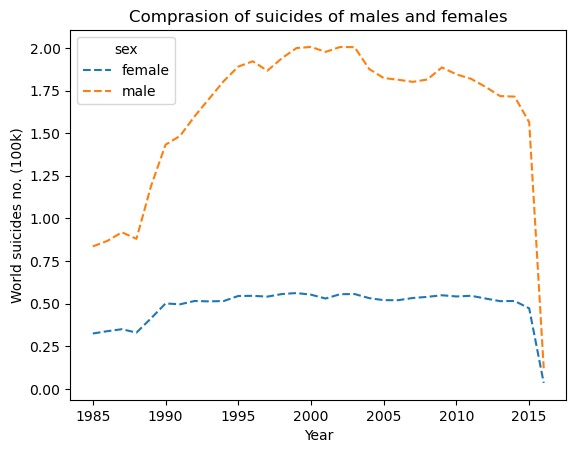

In [302]:
grouped_df = df.groupby(['sex', 'year']).agg(suicides_no_sum=('suicides_no', 'sum')).reset_index()
grouped_df['suicides_no_sum'] = grouped_df['suicides_no_sum'] / 1e5

sns.lineplot(
    grouped_df, x='year', y='suicides_no_sum', hue='sex', linestyle='--'
)
plt.ylabel('World suicides no. (100k)')
plt.xlabel('Year')
plt.title('Comprasion of suicides of males and females')
plt.show()

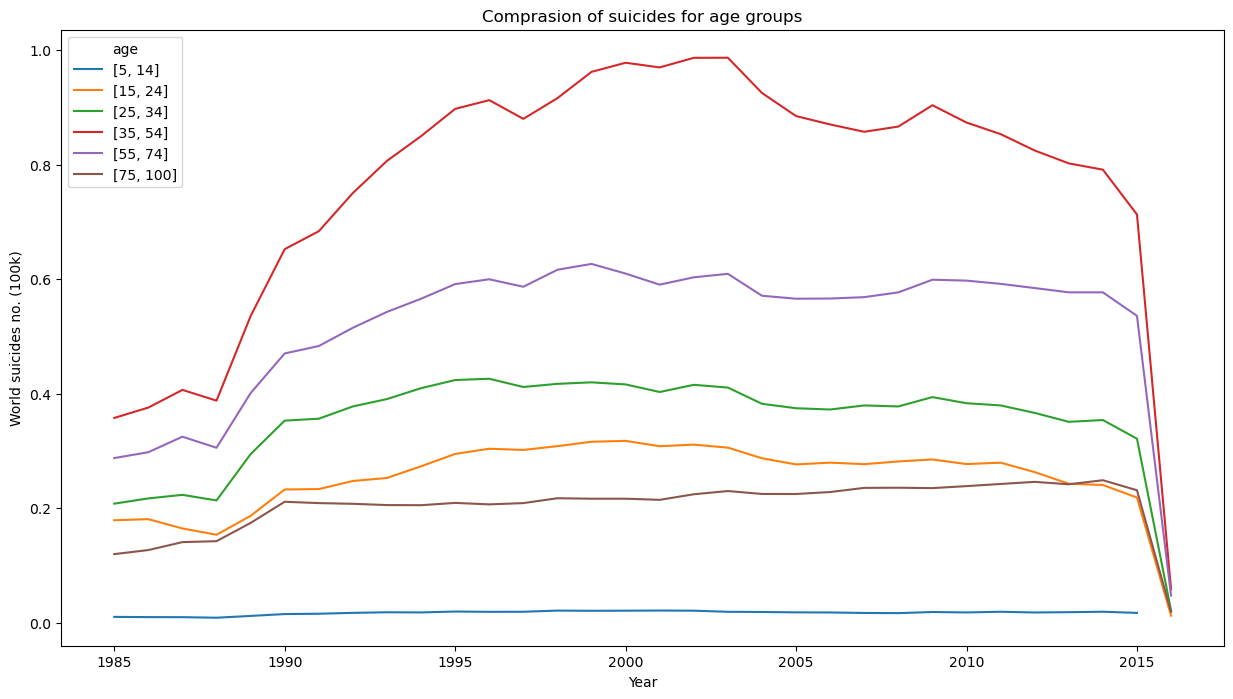

In [311]:
grouped_df = df.groupby(['year', 'age']).agg(suicides_per_age_range=('suicides_no', 'sum')).reset_index()
grouped_df['suicides_per_age_range'] = grouped_df['suicides_per_age_range'] / 1e5

plt.figure(figsize=(15,8))

sns.lineplot(
    grouped_df, x='year', y='suicides_per_age_range', hue='age'
)

plt.ylabel('World suicides no. (100k)')
plt.xlabel('Year')
plt.title('Comprasion of suicides for age groups')
plt.show()

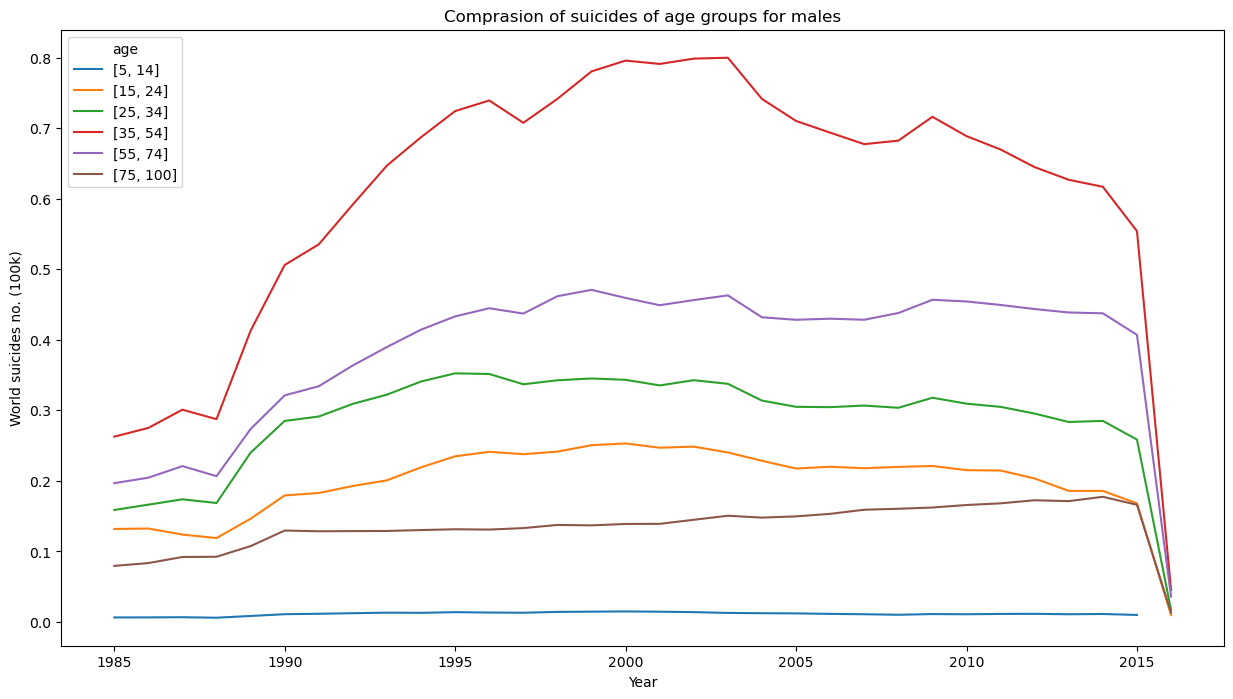

In [320]:
grouped_df = df.groupby(['sex', 'year', 'age']).agg(suicides_per_age_range=('suicides_no', 'sum')).reset_index()
grouped_df['suicides_per_age_range'] = grouped_df['suicides_per_age_range'] / 1e5

plt.figure(figsize=(15,8))

sns.lineplot(
    grouped_df[grouped_df['sex'] == 'male'], x='year', y='suicides_per_age_range', hue='age'
)

plt.ylabel('World suicides no. (100k)')
plt.xlabel('Year')
plt.title('Comprasion of suicides of age groups for males')
plt.show()

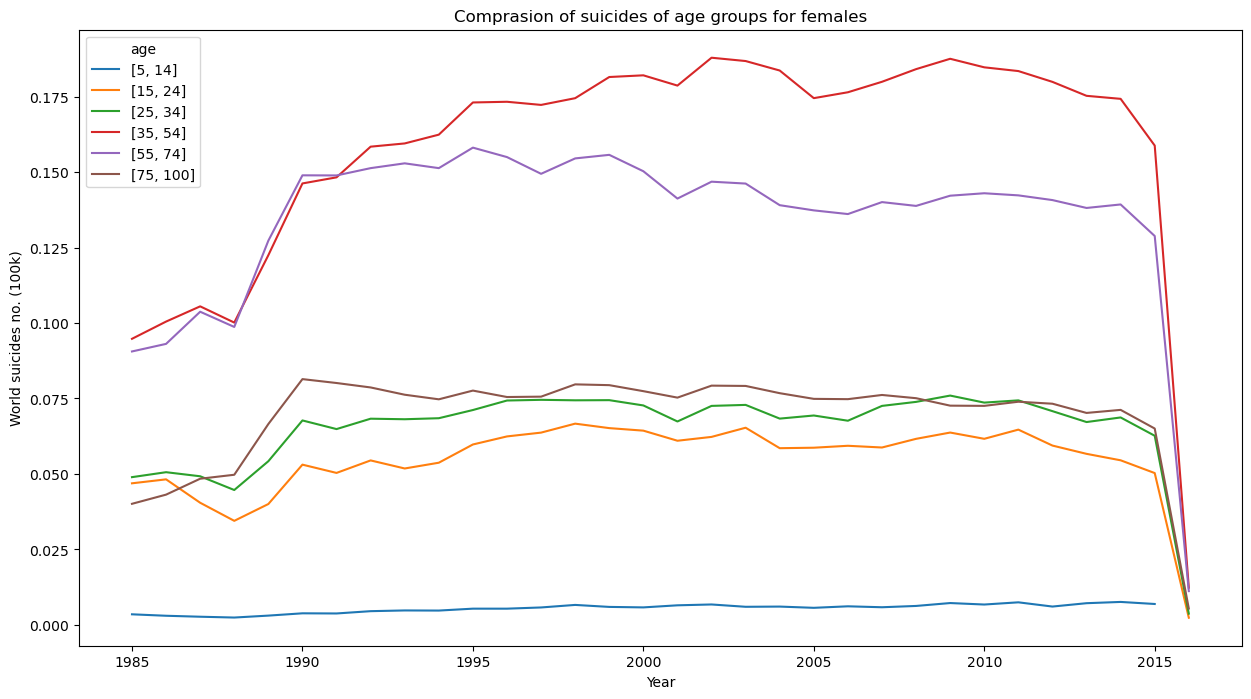

In [321]:

plt.figure(figsize=(15,8))

sns.lineplot(
    grouped_df[grouped_df['sex'] == 'female'], x='year', y='suicides_per_age_range', hue='age'
)

plt.ylabel('World suicides no. (100k)')
plt.xlabel('Year')
plt.title('Comprasion of suicides of age groups for females')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression